## GLS map-making for I, Q, and U components with litebird_sim data using the linear operators explicitly

This example illustrates the GLS map-making for I, Q, and U components from `litebird_sim` data using linear operators explicitly. `BrahMap` offers complete integration with `litebird_sim` eliminating the need to store the TODs and pointings to the disk.

In [1]:
import tempfile
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import healpy as hp
import litebird_sim as lbs
import brahmap

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


### Producing the input maps, pointings and TOD using litebird_sim

In [2]:
### Mission parameters
telescope = "MFT"
channel = "M1-195"
detectors = [
    "001_002_030_00A_195_B",
    "001_002_029_45B_195_B",
    "001_002_015_15A_195_T",
    "001_002_047_00A_195_B",
]
start_time = 51
mission_time_days = 30
detector_sampling_freq = 1

### Simulation parameters
nside = 128
random_seed = 45
imo_version = "vPTEP"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
dtype_float = np.float64
tmp_dir = tempfile.TemporaryDirectory()

In [3]:
### Initializing the simulation
sim = lbs.Simulation(
    random_seed=random_seed,
    base_path=tmp_dir.name,
    name="brahmap_example",
    start_time=start_time,
    duration_s=mission_time_days * 24 * 60 * 60.0,
    imo=imo,
)

In [4]:
### Instrument definition
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

In [5]:
### Detector list
detector_list = []
for n_det in detectors:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = detector_sampling_freq
    detector_list.append(det)

In [6]:
### Scanning strategy
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

In [7]:
### Create observations
sim.create_observations(
    detectors=detector_list,
    num_of_obs_per_detector=3,
    n_blocks_det=1,
    n_blocks_time=1,
    split_list_over_processes=False,
    tod_dtype=dtype_float,
)

In [8]:
### Prepare pointings
sim.prepare_pointings()

In [9]:
### Compute pointings (optional)
sim.precompute_pointings(pointings_dtype=dtype_float)

In [10]:
### Channel info
ch_info = []
n_ch_info = lbs.FreqChannelInfo.from_imo(
    imo,
    f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
)
ch_info.append(n_ch_info)


### CMB map
mbs_params = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,
    gaussian_smooth=True,
    bandpass_int=False,
    nside=nside,
    units="uK_CMB",
    maps_in_ecliptic=False,
    output_string="mbs_cmb_lens",
)

mbs_obj = lbs.Mbs(
    simulation=sim,
    parameters=mbs_params,
    channel_list=ch_info,
)

input_maps = mbs_obj.run_all()

[2025-03-23 14:44:52,898 INFO MPI#0000] generating and saving cmb simulations
[2025-03-23 14:44:52,917 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-03-23 14:44:52,918 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-03-23 14:44:52,964 INFO MPI#0000] Access data from /tmp/tmpg0suqofq/cmb/0000/cmb_0000_mbs_cmb_lens.fits
[2025-03-23 14:44:52,966 INFO MPI#0000] NSIDE = 128
[2025-03-23 14:44:52,967 INFO MPI#0000] ORDERING = RING in fits file
[2025-03-23 14:44:52,967 INFO MPI#0000] INDXSCHM = IMPLICIT
[2025-03-23 14:44:53,039 INFO MPI#0000] Sigma is 11.890505 arcmin (0.003459 rad) 
[2025-03-23 14:44:53,040 INFO MPI#0000] -> fwhm is 28.000000 arcmin
[2025-03-23 14:44:53,042 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-03-23 14:44:53,043 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [11]:
### Scanning the sky
lbs.scan_map_in_observations(
    sim.observations,
    maps=input_maps[0][channel],
)

### Producing the GLS maps

In [12]:
### Initializing the BrahMap environment
brahmap.Initialize()

In [13]:
### Creating an inverse noise covariance operator (unit diagonal operator in this case)
inv_cov = brahmap.LBSim_InvNoiseCovLO_UnCorr(sim.observations)

[2025-03-23 14:44:54,405 INFO MPI#0000] New linear operator with shape (10368000, 10368000)


In [14]:
### Processing the pointing information
processed_samples = brahmap.LBSimProcessTimeSamples(
    nside=nside,
    observations=sim.observations,
    solver_type=brahmap.SolverType.IQU,
    noise_weights=inv_cov.diag,
    dtype_float=dtype_float,
)


-------------------------- ProcessTimeSamples Summary --------------------------
Processed 10368000 time samples for npix=196608
Found 73512 pathological pixels on the map
Map-maker will take into account only 123096 pixels
--------------------------------------------------------------------------------


In [15]:
### Creating pointing operator
pointing_LO = brahmap.PointingLO(processed_samples)

### Creating block-diagonal preconditioner
precond_LO = brahmap.BlockDiagonalPreconditionerLO(processed_samples)

[2025-03-23 14:44:55,207 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-03-23 14:44:55,208 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-03-23 14:44:55,208 INFO MPI#0000] New linear operator with shape (369288, 369288)


In [ ]:
### Concatenating the TODs of all the detectors across all observations
# In order to produce one map for multiple detectors, we simply concatenate the
# pointings and TODs of all the detectors before doing map-making.
# `ProcessTimeSamples` takes care of concatenating pointings and pol_angles. We
# need to concatenate the TOD array ourself in this case:
tod = np.concatenate([getattr(obs, "tod") for obs in sim.observations], axis=None)

In [17]:
### Creating operators for linear equation A.x = b
A = pointing_LO.T * inv_cov * pointing_LO
b = pointing_LO.T * inv_cov * tod

[2025-03-23 14:44:55,242 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-03-23 14:44:55,243 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-03-23 14:44:55,243 INFO MPI#0000] New linear operator with shape (369288, 369288)
[2025-03-23 14:44:55,244 INFO MPI#0000] New linear operator with shape (369288, 369288)
[2025-03-23 14:44:55,244 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-03-23 14:44:55,244 INFO MPI#0000] New linear operator with shape (10368000, 369288)


In [18]:
### Solving GLS using pcg
# We are solving for x in the linear equation A.x = b
map_vector, _ = sp.sparse.linalg.cg(A=A, b=b, M=precond_LO)

In [19]:
### Producing output map masked for bad pixels
# `map_vector` obtained in the previous step contains the output maps in form
# [I_1, Q_1, U_1, I_2, Q_2, U_2, ...] only for the pixels that are being used in
# map-making. To produce the final output maps, we need to separate the I, Q and U
# maps, and mask them appropriately
output_maps = brahmap.separate_map_vectors(
    map_vector=map_vector, processed_samples=processed_samples
)

### Comparing the input and output maps

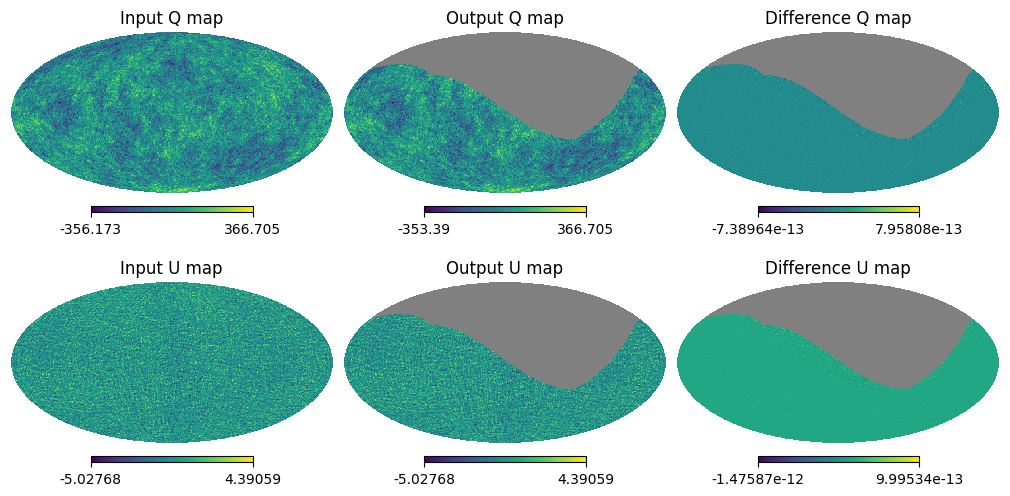

In [20]:
### Plotting and comparing the input and output maps
plt.figure(figsize=(10, 5))

hp.mollview(input_maps[0][channel][0], sub=231, title="Input Q map")
hp.mollview(output_maps[0], sub=232, title="Output Q map")
hp.mollview(
    input_maps[0][channel][0] - output_maps[0], sub=233, title="Difference Q map"
)

hp.mollview(input_maps[0][channel][1], sub=234, title="Input U map")
hp.mollview(output_maps[1], sub=235, title="Output U map")
hp.mollview(
    input_maps[0][channel][1] - output_maps[1], sub=236, title="Difference U map"
)

### Comments on the result

The gray pixels in the output map indicate the bad pixels excluded from the map-making. These are the same pixels reported by `LBSimProcessTimeSamples`.